In [1]:
# Import libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

finwiz_url = 'https://finviz.com/quote.ashx?t='

In [2]:
news_tables = {}
tickers = ['AMZN', 'TSLA', 'GOOG']

for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url,headers={'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:20.0) Gecko/20100101 Firefox/20.0'})
    response = urlopen(req)
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table

In [3]:
# Read one single day of headlines for 'AMZN'
amzn = news_tables['AMZN']
# Get all the table rows tagged in HTML with <tr> into 'amzn_tr'
amzn_tr = amzn.findAll('tr')

for i, table_row in enumerate(amzn_tr):
    # Read the text of the element 'a' into 'link_text'
    a_text = table_row.a.text
    # Read the text of the element 'td' into 'data_text'
    td_text = table_row.td.text
    # Print the contents of 'link_text' and 'data_text'
    print(a_text)
    print(td_text)
    # Exit after printing 4 rows of data
    if i == 3:
        break

HBO subscribers grow to nearly 77 million, United Airlines stock rises on earnings
Apr-21-22 11:42AM  
Amazons new service offers partnership opportunities to companies that dont want to sell on the Amazon site, analyst says
11:14AM  
Elon Musks Boring Company raises $675 million, Obamas to leave Spotify, Amazon debuts new service
10:37AM  
Amazon Plans to Invest $1 Billion in Logistics and Robotics Companies
09:56AM  


In [4]:
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text()
        # splite text in the td tag into a list
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element

        if len(date_scrape) == 1:
            time = date_scrape[0]

        # else load 'date' as the 1st element and 'time' as the second
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the 1st '_'
        ticker = file_name.split('_')[0]

        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])

parsed_news

[['AMZN',
  'Apr-21-22',
  '11:42AM',
  'HBO subscribers grow to nearly 77 million, United Airlines stock rises on earnings'],
 ['AMZN',
  'Apr-21-22',
  '11:14AM',
  'Amazons new service offers partnership opportunities to companies that dont want to sell on the Amazon site, analyst says'],
 ['AMZN',
  'Apr-21-22',
  '10:37AM',
  'Elon Musks Boring Company raises $675 million, Obamas to leave Spotify, Amazon debuts new service'],
 ['AMZN',
  'Apr-21-22',
  '09:56AM',
  'Amazon Plans to Invest $1 Billion in Logistics and\xa0Robotics Companies'],
 ['AMZN',
  'Apr-21-22',
  '09:45AM',
  '7 best VPN services for streaming securely in 2022'],
 ['AMZN', 'Apr-21-22', '09:44AM', 'Amazon launches $1 billion venture fund'],
 ['AMZN',
  'Apr-21-22',
  '09:44AM',
  'Teslas Stock Stands Apart From the Growth Pack: Tech Watch'],
 ['AMZN',
  'Apr-21-22',
  '09:40AM',
  'Market strategist: Investor pessimism rises amid tumultuous year for stocks'],
 ['AMZN',
  'Apr-21-22',
  '09:07AM',
  'Beyond Stoc

In [5]:
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Set column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

parsed_and_scored_news.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,AMZN,2022-04-21,11:42AM,"HBO subscribers grow to nearly 77 million, Uni...",0.000,0.811,0.189,0.4215
1,AMZN,2022-04-21,11:14AM,Amazons new service offers partnership opportu...,0.107,0.694,0.199,0.4548
2,AMZN,2022-04-21,10:37AM,"Elon Musks Boring Company raises $675 million,...",0.203,0.698,0.099,-0.2023
3,AMZN,2022-04-21,09:56AM,Amazon Plans to Invest $1 Billion in Logistics...,0.000,0.855,0.145,0.1779
4,AMZN,2022-04-21,09:45AM,7 best VPN services for streaming securely in ...,0.000,0.476,0.524,0.7650


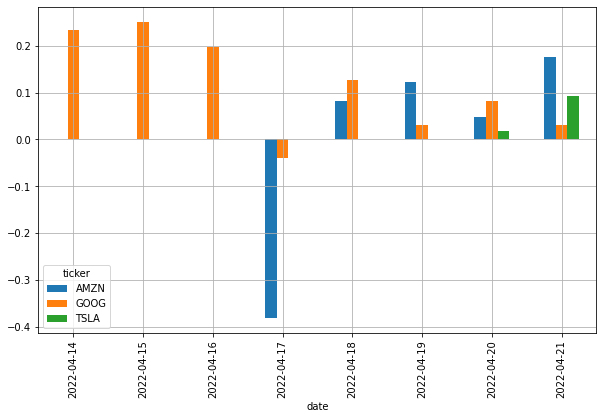

In [6]:
plt.rcParams['figure.figsize'] = [10, 6]

# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()

# Unstack the column ticker
mean_scores = mean_scores.unstack()

# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()

# Plot a bar chart with pandas
mean_scores.plot(kind = 'bar')
plt.grid()